In [3]:
from music21 import corpus, stream, note
import tensorflow as tf
from tensorflow.python.platform import gfile
from tensorflow.python.framework import tensor_util
from google.protobuf import text_format


import collections
import math
import random
import functools
import numpy as np

## some global constants

In [38]:
# number of voices
NUM_VOICES = 4

#number of output classes, i.e. half tone differences to melody
NUM_CLASSES = 26

# duration of time tick in beats. 1=quarter, 0.25=16th 
TIME_TICK = 0.25

# path of the trained model
INPUT_MODEL = "/home/lucky/models/208songsMajorMinor-2"

# minimum and maximum allowed midi key values of the melody
MELODY_MIN_PITCH = 59 # C-3
MELODY_MAX_PITCH = 83

# dir and name of the inference frozen model
FROZEN_MODEL_DIR = "/home/lucky/AnacondaProjects/neuronal-music-accompanist-bach/inference-model"
#FROZEN_MODEL_NAME = "BachAccompanist.frozen.whitelist.pb.whitelist.pbtxt.final.pbtxt"
#MODEL_IS_BINARY = False
#FROZEN_MODEL_NAME = "BachAccompanist.frozen.whitelist.pb"
#MODEL_IS_BINARY = True
FROZEN_MODEL_NAME = "BachAccompanist.frozen.pb"
MODEL_IS_BINARY = True


INPUT_NAME = "input"
OUTPUT_NAME = "output"
COPY_STATES_OP_NAME = "state_update"


## read the frozen inference model from file

In [39]:
# read and test the model
tf.reset_default_graph()

sess = tf.Session()
print("load graph:" + FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME)
graph_def = tf.GraphDef()
if MODEL_IS_BINARY:
    with gfile.FastGFile(FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME,'rb') as f: 
        graph_def.ParseFromString(f.read())
else:
    with open(FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME, "r") as f:
        text_format.Merge(f.read(), graph_def)
        
sess.graph.as_default()
graph_nodes=[n for n in graph_def.node]

tf.import_graph_def(graph_def, name='')

    
sess.run(tf.global_variables_initializer())

#g = tf.Graph()
#g.ParseFromString(open(FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME, "rb").read())
#sess = tf.Session()

#graph_def = sess.graph.as_graph_def()
#tf.train.write_graph(graph_def, FROZEN_MODEL_DIR, \
#        FROZEN_MODEL_NAME+"imported.pbtxt", as_text=True)
#print("written model to ", FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME)

g = sess.graph
tf.summary.FileWriter(FROZEN_MODEL_DIR + "/" + "logFlozen", g).close()

output = sess.graph.get_tensor_by_name(OUTPUT_NAME+":0")
print(output)
copy_states_op = sess.graph.get_operation_by_name(COPY_STATES_OP_NAME)
print(copy_states_op)
in_data = sess.graph.get_tensor_by_name(INPUT_NAME+":0")
print(in_data)

# manually renamed initVar to init in model, but it does still not initialize automatically 
sess.run("initVars")#, {in_data : [0,0]})

# export the graph for tensorboard
logfile = tf.summary.FileWriter(FROZEN_MODEL_DIR + "/" + "logFrozen", sess.graph)   
                

load graph:/home/lucky/AnacondaProjects/neuronal-music-accompanist-bach/inference-model/BachAccompanist.frozen.pb


ValueError: graph_def is invalid at node 'rnn/multi_rnn_cell/cell_0/lstm_cell/w_f_diag/Assign': Input tensor 'rnn/multi_rnn_cell/cell_0/lstm_cell/w_f_diag:0' Cannot convert a tensor of type float32 to an input of type float32_ref.


## Apply the inference model
get a choral from the music21 Bach library and input the melody notes one by one to the rnn.


In [6]:
def extractMelody(music):
    min_midi = 256
    max_midi = 0
    melody = []
    currentOffset = 0
    for n in music.parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += TIME_TICK;
        noteTicks = math.floor(n.duration.quarterLength / TIME_TICK)
        min_midi = min(min_midi, n.pitch.midi)
        max_midi = max(max_midi, n.pitch.midi)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, n.pitch.midi, 1])
            else:
                melody.append([currentOffset, n.pitch.midi, 0])
            currentOffset += TIME_TICK;
    #print("Melody min/max midi pitch: %d/%d" % (min_midi, max_midi))
    return melody

In [7]:
# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to NUM_CLASSES. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    diff = melody - voice
    if diff < 0:  raise Exception("Error: voice above melody")
    # -1 for adding 1 below, additionl -1 so that diff can be index 
    while (diff > NUM_CLASSES - 2):
        diff -= 12
    return diff + 1

In [8]:
def extractVoices(melody, music):
    for partIndex in range(1, len(music.parts)):
        partNotes = music.parts[partIndex].flat.notes
        noteIndex = 0;
        maxNoteIndex = len(partNotes)
        
        for n in melody:
            #print(n)
            currentOffset = n[0]
            if (noteIndex < maxNoteIndex):
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
                    # skip to next note
                    noteIndex += 1
            if (noteIndex < maxNoteIndex):                
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)

In [9]:
songs = []
streams = []
for name in corpus.chorales.Iterator(1, 3, returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and highestTime < 68: 
        # and song.parts[0].flat.getTimeSignatures()[0].numerator == 3 and key.mode == 'major' 
        
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            print('%3d: %s: %s, %d, %s voices, duration: %s' % (
                len(songs), name, key, song.parts[0].flat.getTimeSignatures()[0].numerator, len(song.parts), highestTime))
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

  1: bach/bwv153.1: a minor, 4, 4 voices, duration: 56.0


In [10]:
print(len(songs))

1


In [11]:
def createStream(music, numVoices=4):
    sc = stream.Score()
    notes = []
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    for tick in music:
        for voice in range (0, numVoices):
            part = sc.parts[voice]
            pitchIndex = 1 + voice * 2
            strikeIndex = 1 + voice * 2 + 1
            # extend note
            if notes[voice] != None and tick[strikeIndex] == 0:
                notes[voice].quarterLength += TIME_TICK
            
            if tick[strikeIndex] == 1:
                if (tick[pitchIndex]) > 0:
                    #create new note
                    n = note.Note()
                    notes[voice] = n
                    n.offset = tick[0]
                    if (voice == 0):
                        #melody voice
                        n.pitch.midi = tick[pitchIndex]
                    else:
                        #other voices relative to melody
                        n.pitch.midi = tick[pitchIndex] + 1
                    n.quarterLength = TIME_TICK
                    part.append(n)
                else:
                    n = note.Rest()
                    notes[voice] = n
                    n.offset = tick[0]
                    n.quarterLength = TIME_TICK
                    part.append(n)
    return sc
    
                        

In [12]:

def read_dataset(songs, NUM_VOICES = 4):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print("max sequence length: ", max_seq_length)
    
    m = len(songs)  
    print("num samples: ", m)
    X=[]
    Y=[]
    for sg in songs:
        x=[]
        y=[]
        #print(sg)
        for tick in sg:
            #print(tick)
            # add melody
            x.append([tick[1], tick[2]])
           
            voices = []
            # write voice pitch
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2
                #print(oneHot)
                voices.append(tick[voice_index] + tick[1])
            # write voice strike
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2 + 1
                #print(oneHot)
                voices.append(tick[voice_index])
            y.append(voices)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
        # pad songs
        padding_length = max_seq_length - len(x)
        #print("padding:", padding_length)
        for i in range (0, padding_length):
            x.append([0] * 2)
            voices = []
            for voice in range(NUM_VOICES - 1):
                voices.append(np.zeros(2))
            y.append(voices)
        X.append(x)
        Y.append(y)   
    #print(Y[0])
    data = np.array(X)
    print("data: ", data.shape)
    target = np.array(Y)
    print("target: ", target.shape)
    dataset = {'data': data , 'target' : target, 'seq_length' : np.array(seq_length)}
    return dataset

train = read_dataset(songs)


max sequence length:  224
num samples:  1
data:  (1, 224, 2)
target:  (1, 224, 6)


In [13]:
from music21 import midi
def export_dataset(inSongs, prediction, NUM_VOICES = 4, strike_probability = 0.7):
    predSongs = []
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (NUM_VOICES - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2]]
            for voice in range(NUM_VOICES - 1):
                predPitch = predPitches[voice]
                newPitch = voices[tickNum, voice]
                strike = voices[tickNum, voice + NUM_VOICES - 1] > strike_probability
                if not strike and predPitch > 0:
                    # if no strike than note cannot change
                    pitch = predPitch                
                else: pitch = newPitch
                tick.append(pitch)
                tick.append(strike)
                predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += TIME_TICK
        predSongs.append(song)
    return predSongs


In [21]:
predSongPieces = []
prediction = np.ndarray(shape=(1, 0, 6),  dtype=float)
print("sequence length: ", len(train['data'][0]))
for tick in range(len(train['data'][0])):
    tick_data = train['data'][0, tick]
    #print(tick_data)
    
    #output_step = sess.run([output_op], {in_data : tick_data})
    prediction_step = sess.run(output, {in_data : tick_data})
    #print(prediction_step)
    _ = sess.run(copy_states_op, {in_data : tick_data})
    logfile.close()
    prediction = np.concatenate((prediction, prediction_step.reshape([1, 1, -1])), axis = 1)
    predSongPiece = export_dataset(songs, prediction)
    predSongPieces.append(predSongPiece[0])
        

sequence length:  224


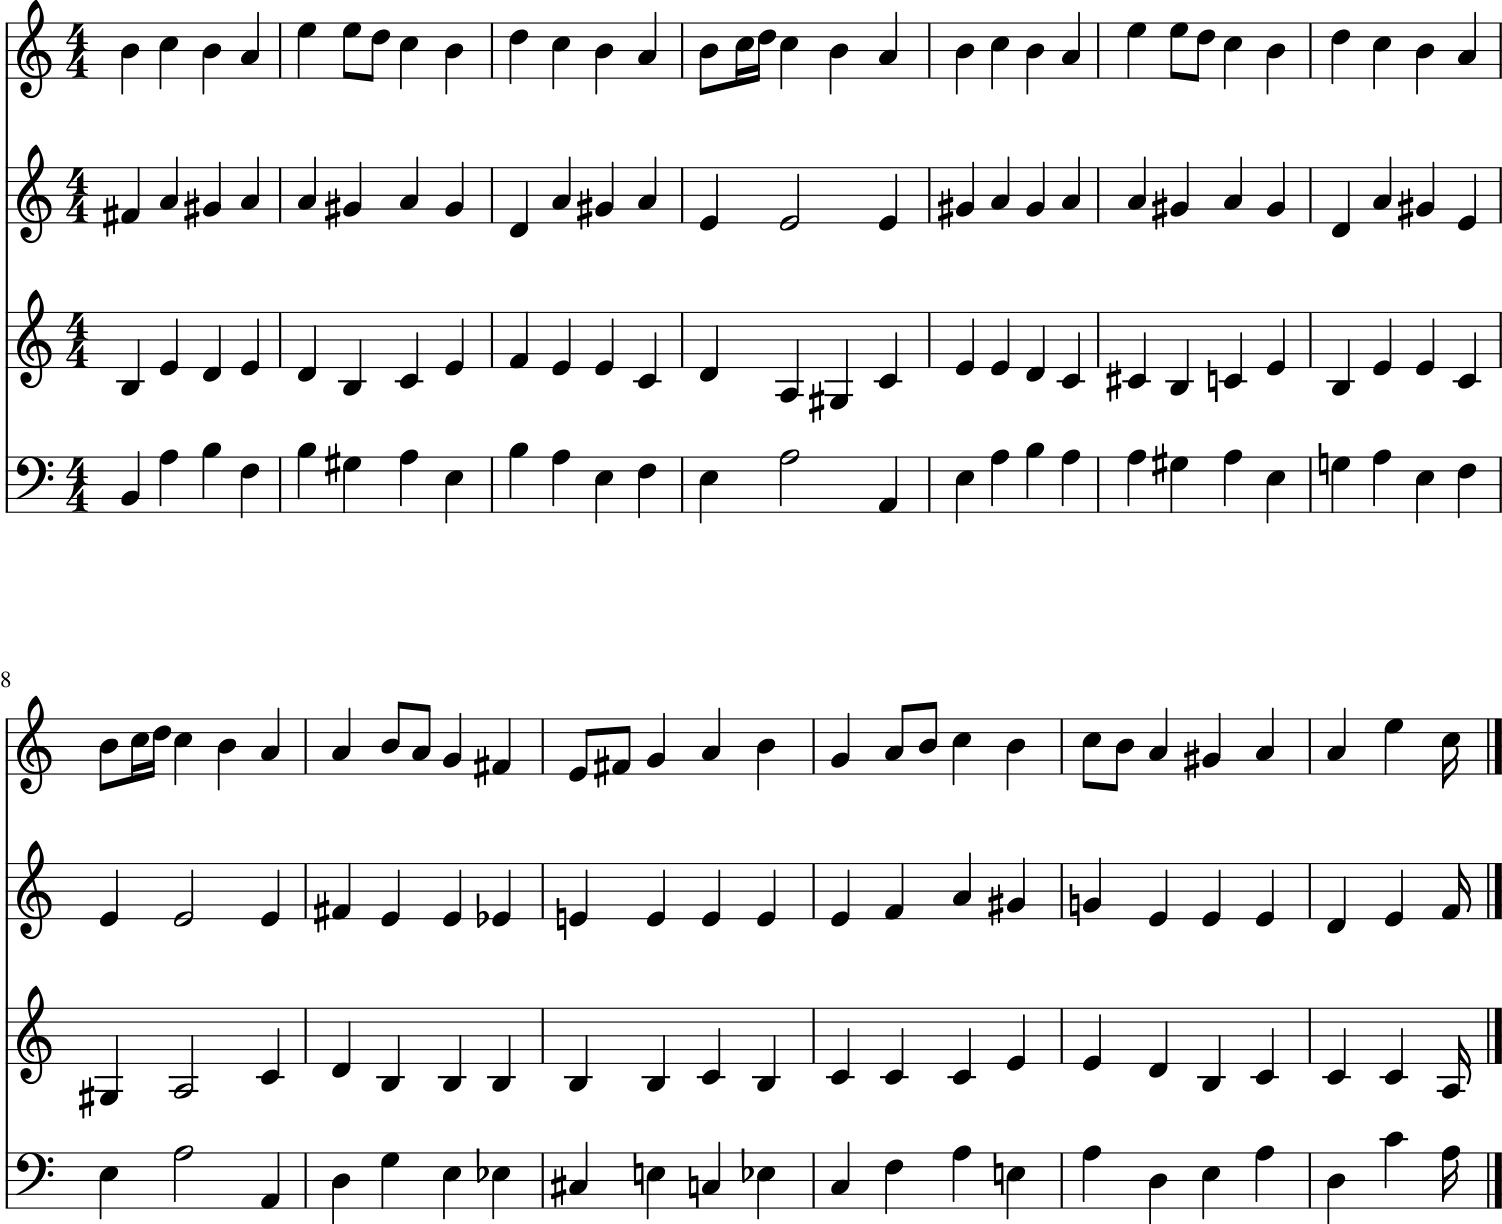

In [22]:
songNum = 200 # song containing the first 16 ticks - the first measure
sc = createStream(predSongPieces[songNum], 4)
sc.show()
sc.show('midi')


In [28]:
# export as frozen graph

tf.train.write_graph(g, FROZEN_MODEL_DIR, \
     FROZEN_MODEL_NAME, as_text=True)
print("written model to ", FROZEN_MODEL_DIR, "/", FROZEN_MODEL_NAME)

written model to  /home/lucky/AnacondaProjects/neuronal-music-accompanist-bach/inference-model / BachAccompanist.frozen.whitelist.pb.whitelist.pbtxt.final.pbtxt


In [29]:
init_all_op = tf.model_variables()
print(init_all_op)

[]
